In [13]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
from collections import defaultdict


# Config


In [14]:
class Config:
    DATASET_PATH = "/kaggle/input/datasets/jangedoo/utkface-new"
    IMAGES_DIR1 = os.path.join(DATASET_PATH, "UTKFace")
    IMAGES_DIR2 = os.path.join(DATASET_PATH, "crop_part1")

    WORK_DIR = "/kaggle/working/"
    CHECKPOINT_DIR = os.path.join(WORK_DIR, "checkpoints")
    RESULTS_DIR = os.path.join(WORK_DIR, "results")

    IMAGE_SIZE = 200        
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4

    TEST_SIZE = 0.15
    VAL_SIZE = 0.15         
    SEED = 42

    MAX_AGE = 100    
    GRAD_CLIP = 1.0
    EARLY_STOPPING_PATIENCE = 8

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 2
    PIN_MEMORY = True

cfg = Config()

os.makedirs(cfg.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(cfg.RESULTS_DIR, exist_ok=True)

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything(cfg.SEED)

# Data

In [15]:
def parse_utk_filename(filename: str):
    parts = filename.split("_")
    if len(parts) < 4:
        return None
    try:
        age = int(parts[0])
        gender = int(parts[1])
        race = int(parts[2])
        return age, gender, race
    except:
        return None

def build_dataframe():
    data = []
    for folder in [cfg.IMAGES_DIR1, cfg.IMAGES_DIR2]:
        if not os.path.isdir(folder):
            continue
        for fn in os.listdir(folder):
            if not fn.lower().endswith(".jpg"):
                continue
            parsed = parse_utk_filename(fn)
            if parsed is None:
                continue
            age, gender, race = parsed

            if age < 0 or age > 116:
                continue

            data.append({
                "filename": fn,
                "age": age,
                "gender": gender,
                "race": race,
                "path": os.path.join(folder, fn)
            })
    df = pd.DataFrame(data)
    return df

class AgeDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, max_age: int = 100):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.max_age = float(max_age)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.loc[idx]
        img = Image.open(row["path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        age_years = float(row["age"])
        age_norm = min(max(age_years / self.max_age, 0.0), 1.0)

        return {
            "image": img,
            "age_norm": torch.tensor(age_norm, dtype=torch.float32),
            "age_years": torch.tensor(age_years, dtype=torch.float32),
        }

def get_transforms(train: bool):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(cfg.IMAGE_SIZE, scale=(0.85, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

In [16]:
def run_eda(df: pd.DataFrame, n_img: int = 16, seed: int = 42):
    rng = np.random.default_rng(seed)

    print("=== EDA: overview ===")
    print("rows:", len(df))
    print(df.head(3))
    print("\nMissing values:\n", df.isna().sum())
    print("\nAge summary:\n", df["age"].describe())

    plt.figure(figsize=(10, 4))
    plt.hist(df["age"].values, bins=50)
    plt.title("Age distribution (years)")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()

    if "gender" in df.columns:
        gender_counts = df["gender"].value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        plt.bar(gender_counts.index.astype(str), gender_counts.values)
        plt.title("Gender counts (0/1)")
        plt.xlabel("Gender")
        plt.ylabel("Count")
        plt.grid(True, axis="y", alpha=0.3)
        plt.show()

        g0 = df.loc[df["gender"] == 0, "age"].values
        g1 = df.loc[df["gender"] == 1, "age"].values

        plt.figure(figsize=(6, 4))
        plt.boxplot([g0, g1], tick_labels=["gender=0", "gender=1"], showfliers=False)
        plt.title("Age by gender (boxplot)")
        plt.ylabel("Age")
        plt.grid(True, axis="y", alpha=0.3)
        plt.show()

    if "race" in df.columns:
        race_counts = df["race"].value_counts().sort_index()
        plt.figure(figsize=(8, 4))
        plt.bar(race_counts.index.astype(str), race_counts.values)
        plt.title("Race counts (UTKFace label id)")
        plt.xlabel("Race id")
        plt.ylabel("Count")
        plt.grid(True, axis="y", alpha=0.3)
        plt.show()

    n_img = int(min(n_img, len(df)))
    if n_img > 0 and "path" in df.columns:
        sample_idx = rng.choice(len(df), size=n_img, replace=False)
        sample = df.iloc[sample_idx].reset_index(drop=True)

        cols = int(np.ceil(np.sqrt(n_img)))
        rows = int(np.ceil(n_img / cols))

        plt.figure(figsize=(3 * cols, 3 * rows))
        for i in range(n_img):
            row = sample.iloc[i]
            try:
                img = Image.open(row["path"]).convert("RGB")
            except Exception:
                continue

            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"age={row['age']} g={row.get('gender','?')} r={row.get('race','?')}", fontsize=9)

        plt.suptitle("Random samples", y=1.02)
        plt.tight_layout()
        plt.show()

# Model

In [17]:
def conv_block(in_ch, out_ch, k=3, p=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class AgeCNN(nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            nn.MaxPool2d(2),

            conv_block(32, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2),

            conv_block(64, 128),
            conv_block(128, 128),
            nn.MaxPool2d(2),

            conv_block(128, 256),
            nn.MaxPool2d(2),
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x).squeeze(1)
        x = torch.sigmoid(x)
        return x


# Training

In [18]:
def to_years(x_norm: torch.Tensor) -> torch.Tensor:
    return x_norm * cfg.MAX_AGE

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_mae_years = 0.0
    n = 0

    for batch in loader:
        images = batch["image"].to(device, non_blocking=True)
        targets = batch["age_norm"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        preds = model(images)
        loss = criterion(preds, targets)
        loss.backward()

        if cfg.GRAD_CLIP and cfg.GRAD_CLIP > 0:
            nn.utils.clip_grad_norm_(model.parameters(), cfg.GRAD_CLIP)

        optimizer.step()

        bs = images.size(0)
        total_loss += loss.item() * bs

        mae_years = torch.mean(torch.abs(to_years(preds.detach()) - to_years(targets))).item()
        total_mae_years += mae_years * bs
        n += bs

    return total_loss / n, total_mae_years / n

@torch.no_grad()
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_mae_years = 0.0
    n = 0

    all_pred_years = []
    all_true_years = []

    for batch in loader:
        images = batch["image"].to(device, non_blocking=True)
        targets = batch["age_norm"].to(device, non_blocking=True)
        preds = model(images)

        loss = criterion(preds, targets)

        bs = images.size(0)
        total_loss += loss.item() * bs

        pred_y = to_years(preds).cpu().numpy().reshape(-1)
        true_y = to_years(targets).cpu().numpy().reshape(-1)

        all_pred_years.append(pred_y)
        all_true_years.append(true_y)

        total_mae_years += np.mean(np.abs(pred_y - true_y)) * bs
        n += bs

    all_pred_years = np.concatenate(all_pred_years)
    all_true_years = np.concatenate(all_true_years)

    mse = mean_squared_error(all_true_years, all_pred_years)
    rmse = float(np.sqrt(mse))
    r2 = float(r2_score(all_true_years, all_pred_years))
    acc_5 = float(np.mean(np.abs(all_true_years - all_pred_years) <= 5) * 100)
    acc_10 = float(np.mean(np.abs(all_true_years - all_pred_years) <= 10) * 100)

    return {
        "loss": total_loss / n,
        "mae_years": total_mae_years / n,
        "rmse": rmse,
        "r2": r2,
        "acc_5": acc_5,
        "acc_10": acc_10,
    }

In [19]:
def main():
    df = build_dataframe()
    if len(df) == 0:
        raise RuntimeError("Нет изображений.")

    run_eda(df, n_img=16, seed=cfg.SEED)

    age_bins = pd.cut(df["age"], bins=[-1, 5, 12, 18, 30, 45, 60, 80, 200], labels=False)
    train_df, test_df = train_test_split(
        df, test_size=cfg.TEST_SIZE, random_state=cfg.SEED, stratify=age_bins
    )

    age_bins_train = pd.cut(train_df["age"], bins=[-1, 5, 12, 18, 30, 45, 60, 80, 200], labels=False)
    train_df, val_df = train_test_split(
        train_df, test_size=cfg.VAL_SIZE, random_state=cfg.SEED, stratify=age_bins_train
    )

    print(f"Total: {len(df)} | Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

    train_ds = AgeDataset(train_df, transform=get_transforms(train=True), max_age=cfg.MAX_AGE)
    val_ds   = AgeDataset(val_df, transform=get_transforms(train=False), max_age=cfg.MAX_AGE)
    test_ds  = AgeDataset(test_df, transform=get_transforms(train=False), max_age=cfg.MAX_AGE)

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
                              num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,
                            num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY)
    test_loader = DataLoader(test_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,
                             num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY)

    model = AgeCNN(dropout=0.4).to(cfg.DEVICE)

    criterion = nn.SmoothL1Loss(beta=0.02) 
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.NUM_EPOCHS)

    best_val = float("inf")
    best_path = os.path.join(cfg.CHECKPOINT_DIR, "best_agecnn.pt")
    es = 0

    for epoch in range(1, cfg.NUM_EPOCHS + 1):
        tr_loss, tr_mae = train_epoch(model, train_loader, criterion, optimizer, cfg.DEVICE)
        val_metrics = validate_epoch(model, val_loader, criterion, cfg.DEVICE)
        scheduler.step()

        print(f"[{epoch:02d}/{cfg.NUM_EPOCHS}] "
              f"train_loss={tr_loss:.4f} train_MAE={tr_mae:.2f}y | "
              f"val_loss={val_metrics['loss']:.4f} val_MAE={val_metrics['mae_years']:.2f}y "
              f"acc@5={val_metrics['acc_5']:.1f}% acc@10={val_metrics['acc_10']:.1f}%")

        if val_metrics["mae_years"] < best_val:
            best_val = val_metrics["mae_years"]
            torch.save({"model": model.state_dict(), "cfg": cfg.__dict__}, best_path)
            es = 0
        else:
            es += 1
            if es >= cfg.EARLY_STOPPING_PATIENCE:
                print("Early stopping.")
                break

    ckpt = torch.load(best_path, map_location=cfg.DEVICE)
    model.load_state_dict(ckpt["model"])
    test_metrics = validate_epoch(model, test_loader, criterion, cfg.DEVICE)
    print("\nTEST:")
    print(test_metrics)


=== EDA: overview ===
rows: 33483
                                filename  age  gender  race  \
0  26_0_2_20170104023102422.jpg.chip.jpg   26       0     2   
1  22_1_1_20170112233644761.jpg.chip.jpg   22       1     1   
2  21_1_3_20170105003215901.jpg.chip.jpg   21       1     3   

                                                path  
0  /kaggle/input/datasets/jangedoo/utkface-new/UT...  
1  /kaggle/input/datasets/jangedoo/utkface-new/UT...  
2  /kaggle/input/datasets/jangedoo/utkface-new/UT...  

Missing values:
 filename    0
age         0
gender      0
race        0
path        0
dtype: int64

Age summary:
 count    33483.000000
mean        32.166144
std         21.501741
min          1.000000
25%         18.000000
50%         28.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


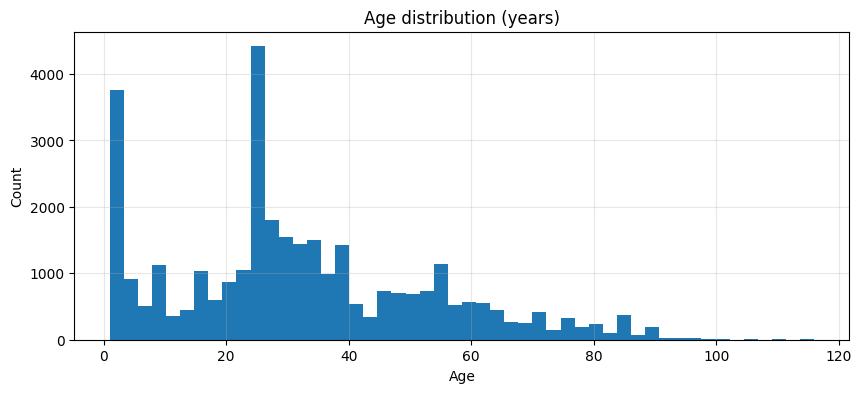

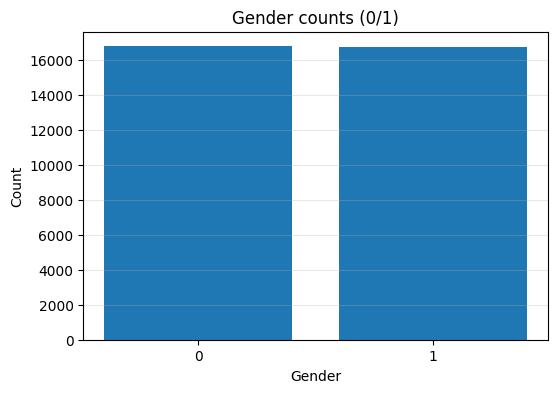

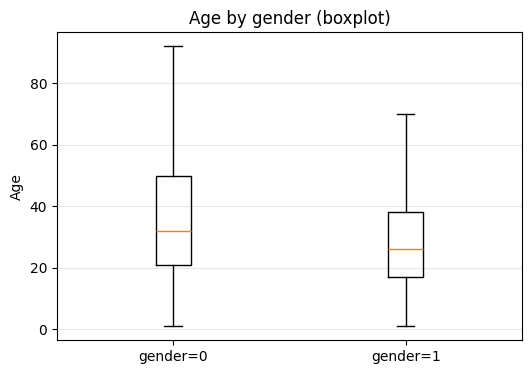

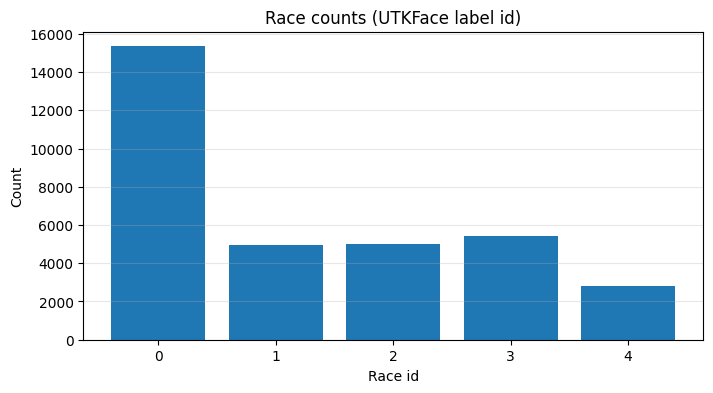

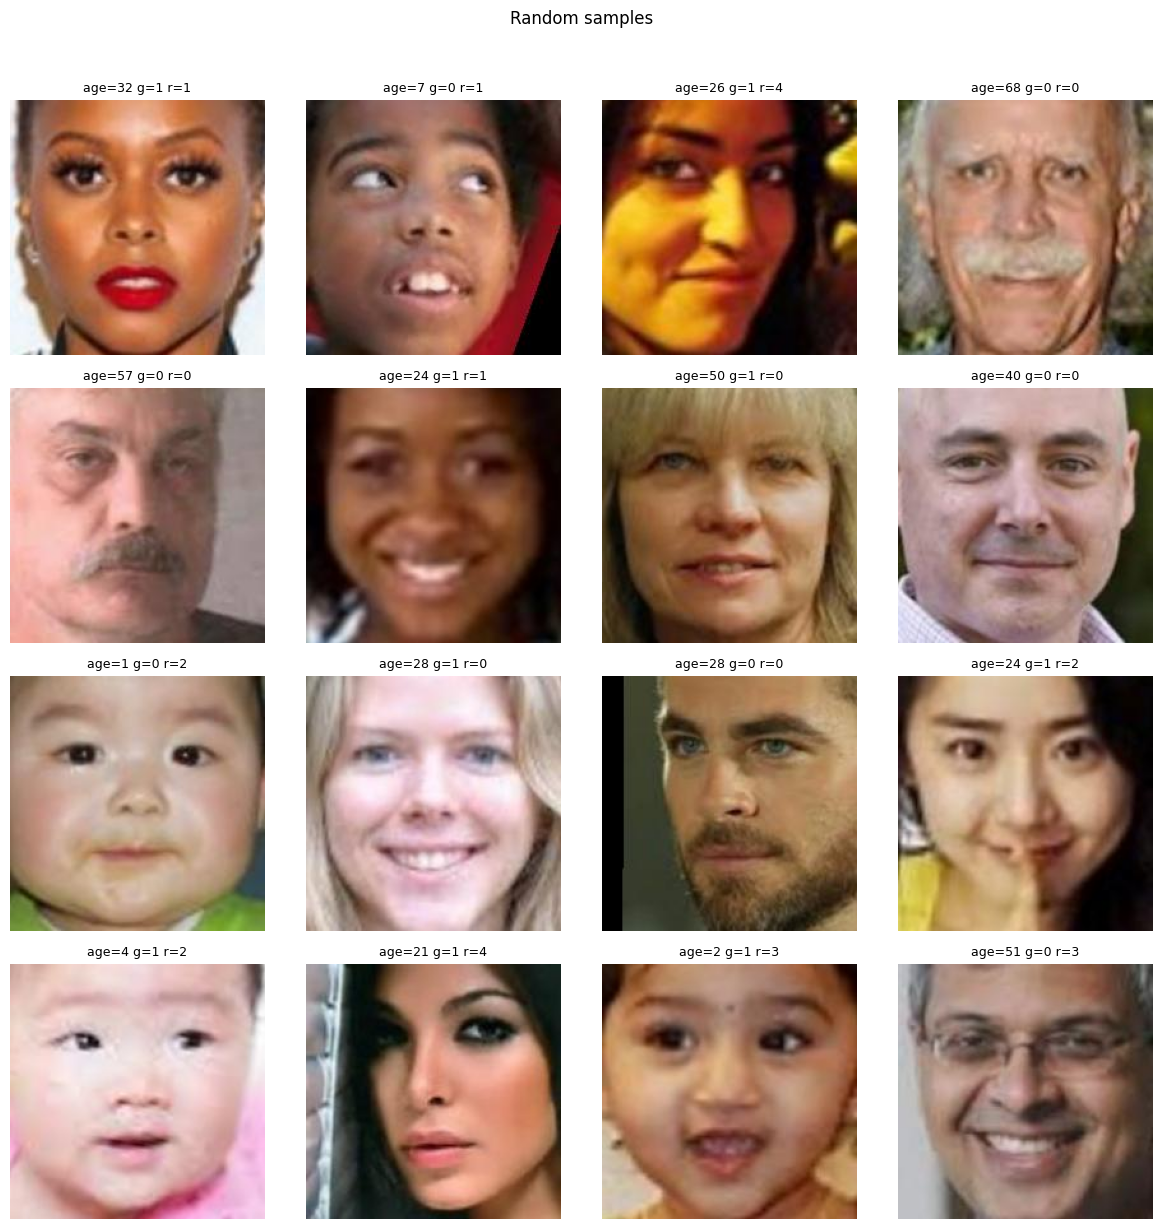

Total: 33483 | Train: 24191 | Val: 4269 | Test: 5023
[01/30] train_loss=0.1252 train_MAE=13.48y | val_loss=0.0973 val_MAE=10.68y acc@5=34.7% acc@10=59.4%
[02/30] train_loss=0.0993 train_MAE=10.88y | val_loss=0.1128 val_MAE=12.25y acc@5=25.5% acc@10=50.1%
[03/30] train_loss=0.0905 train_MAE=9.99y | val_loss=0.0974 val_MAE=10.68y acc@5=35.1% acc@10=58.5%
[04/30] train_loss=0.0856 train_MAE=9.49y | val_loss=0.0807 val_MAE=9.00y acc@5=40.9% acc@10=66.8%
[05/30] train_loss=0.0818 train_MAE=9.11y | val_loss=0.0767 val_MAE=8.60y acc@5=42.7% acc@10=67.7%
[06/30] train_loss=0.0782 train_MAE=8.74y | val_loss=0.0717 val_MAE=8.08y acc@5=45.4% acc@10=70.9%
[07/30] train_loss=0.0758 train_MAE=8.50y | val_loss=0.0712 val_MAE=8.04y acc@5=44.9% acc@10=70.7%
[08/30] train_loss=0.0743 train_MAE=8.35y | val_loss=0.0807 val_MAE=8.98y acc@5=44.7% acc@10=66.8%
[09/30] train_loss=0.0722 train_MAE=8.14y | val_loss=0.0641 val_MAE=7.32y acc@5=48.6% acc@10=74.7%
[10/30] train_loss=0.0705 train_MAE=7.97y | val_los

In [20]:
if __name__ == "__main__":
    main()

In [21]:
import shutil
shutil.make_archive('checkpoints', 'zip', '/kaggle/working/checkpoints')
from IPython.display import FileLink
FileLink(r'checkpoints.zip')


/kaggle/working/checkpoints.zip